# Cyber Operations Data

The Council of Foreign Relations tracks known cyber operations and threat actor groups at https://www.cfr.org/interactive/cyber-operations#CyberOperations

The data _categorizes all instances of publicly known state-sponsored cyber activity since 2005_. Only incidents in which the threat actor is suspected to be affiliated with a nation-state are included. Only incidents where states and their proxies conduct cyber operations in pursuit of their foreign policy interests are included. Furthermore, state-sponsored incidents generally have the most accurate and comprehensive reporting. 

Data sources include: Florian Roth’s APT Groups and Operations spreadsheet, the Center for Strategic and International Studies’ list of significant cyber events, and Kaspersky Lab’s Targeted Cyberattacks Logbook

Attributinon is tricky and is derived using a combination of technical data, open-source information, and an understanding of the threat actor’s foreign policy priorities.

No claims are made that the data contained within the tracker is entirely complete. There is a bias toward over-reporting incidents or threat actors affecting countries where English is widely spoken and published. Classified and proprietary information about incidents are not included. Incident reporting takes  time--some incidents get an attribution way after the operation becomes public. Some incidents may be missing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#you need the inline comment
import matplotlib
%matplotlib inline

#correct statement to set options:
pd.set_option('display.max_columns', 200)

matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
data_file = 'data/cyber-operations-incidents.csv'

first = pd.read_csv(data_file)
first.head(5)

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3
0,Compromise of Bayer Pharmaceuticals,2019-04-04,Wicked Panda,A threat actor put malicious software on Bayer...,NaN,Bayer Pharmaceuticals,China,Data destruction,Private sector,https://www.cyberscoop.com/bayer-breached-chin...,NaN,NaN
1,Cyber espionage by the United Arab Emirates (UAE),2019-01-30,Believed to be the work of the UAE government.,Former U.S. government intelligence operatives...,NaN,"Qatar, Turkey, Yemen",United Arab Emirates,Espionage,"Government, Civil society",https://www.reuters.com/article/us-usa-spying-...,https://www.nbcnews.com/tech/security/how-uae-...,NaN
2,Operation Soft Cell,2019-06-25,APT 10,This threat actor hacked global telecommunicat...,NaN,Global telecommunications companies,China,Espionage,Private sector,https://www.cybereason.com/blog/operation-soft...,NaN,NaN
3,Targeting of U.S. and European think tanks,2019-01-31,Believed to be the work of Fancy Bear.,Hackers set up fake login pages or sent spoof ...,NaN,Center for Strategic and International Studies...,Russian Federation,Espionage,Private sector,https://www.cnn.com/2019/01/30/politics/fancy-...,https://www.newsweek.com/russian-military-inte...,NaN
4,Attack on Iranian computer systems,2019-06-22,U.S. Cyber Command,U.S. Cyber Command hacked Iranian rocket and m...,Denouncement https://www.reuters.com/article...,Iranian rocket and missile launch systems,United States,Sabotage,Military,https://www.nytimes.com/2019/06/22/us/politics...,NaN,NaN


In [3]:
first.shape

(323, 12)

In [4]:
first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 12 columns):
Title           323 non-null object
Date            323 non-null object
Affiliations    202 non-null object
Description     323 non-null object
Response        66 non-null object
Victims         319 non-null object
Sponsor         289 non-null object
Type            314 non-null object
Category        322 non-null object
Sources_1       323 non-null object
Sources_2       246 non-null object
Sources_3       146 non-null object
dtypes: object(12)
memory usage: 30.4+ KB


## Clean up data, Populate fields

In [5]:
first.Sponsor.replace({'Iran (Islamic Republic of)':'Iran', 
               "Korea (Democratic People's Republic of)": "North Korea",
               "United States, Australia, Canada, New Zealand, United Kingdom":"Allies",
               'China, Russian Federation':"China/Russia",
                'United Kingdom, United States':'Allies',
                'United States, Israel':"Allies",
                'Israel, United States':"Allies",
                'Taiwan, United States':"Allies"}, inplace=True)
first.Sponsor.unique()

array(['China', 'United Arab Emirates', 'Russian Federation',
       'United States', 'Allies', 'Iran', nan, 'China/Russia',
       'United Kingdom', 'North Korea', 'Saudi Arabia', 'Pakistan',
       'Lebanon', 'Mexico', 'Netherlands', 'Panama', 'Israel', 'Ethiopia',
       'Kazakhstan', 'Vietnam', 'Spain', 'France', 'Korea (Republic of)',
       'India'], dtype=object)

In [6]:
first.drop(['Sources_1','Sources_2','Sources_3'],axis=1)
first['Year'] = pd.to_datetime(first['Date']) 
first['Year'] = pd.DatetimeIndex(first['Date']).year

In [7]:
first.Year.isna().value_counts()

False    323
Name: Year, dtype: int64

In [8]:
first.Sponsor.unique()

array(['China', 'United Arab Emirates', 'Russian Federation',
       'United States', 'Allies', 'Iran', nan, 'China/Russia',
       'United Kingdom', 'North Korea', 'Saudi Arabia', 'Pakistan',
       'Lebanon', 'Mexico', 'Netherlands', 'Panama', 'Israel', 'Ethiopia',
       'Kazakhstan', 'Vietnam', 'Spain', 'France', 'Korea (Republic of)',
       'India'], dtype=object)

In [9]:
# True in this case means NaN
first.Sponsor.isna().value_counts()

False    289
True      34
Name: Sponsor, dtype: int64

In [10]:
first.Sponsor.replace(np.nan,'Unknown', inplace=True)
first

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3,Year
0,Compromise of Bayer Pharmaceuticals,2019-04-04,Wicked Panda,A threat actor put malicious software on Bayer...,NaN,Bayer Pharmaceuticals,China,Data destruction,Private sector,https://www.cyberscoop.com/bayer-breached-chin...,NaN,NaN,2019
1,Cyber espionage by the United Arab Emirates (UAE),2019-01-30,Believed to be the work of the UAE government.,Former U.S. government intelligence operatives...,NaN,"Qatar, Turkey, Yemen",United Arab Emirates,Espionage,"Government, Civil society",https://www.reuters.com/article/us-usa-spying-...,https://www.nbcnews.com/tech/security/how-uae-...,NaN,2019
2,Operation Soft Cell,2019-06-25,APT 10,This threat actor hacked global telecommunicat...,NaN,Global telecommunications companies,China,Espionage,Private sector,https://www.cybereason.com/blog/operation-soft...,NaN,NaN,2019
3,Targeting of U.S. and European think tanks,2019-01-31,Believed to be the work of Fancy Bear.,Hackers set up fake login pages or sent spoof ...,NaN,Center for Strategic and International Studies...,Russian Federation,Espionage,Private sector,https://www.cnn.com/2019/01/30/politics/fancy-...,https://www.newsweek.com/russian-military-inte...,NaN,2019
4,Attack on Iranian computer systems,2019-06-22,U.S. Cyber Command,U.S. Cyber Command hacked Iranian rocket and m...,Denouncement https://www.reuters.com/article...,Iranian rocket and missile launch systems,United States,Sabotage,Military,https://www.nytimes.com/2019/06/22/us/politics...,NaN,NaN,2019
5,Targeting of Visma,2019-02-06,Believed to be the work of APT 10.,Hackers used malware from the dark web to targ...,NaN,Visma,China,Espionage,Private sector,https://www.recordedfuture.com/apt10-cyberespi...,https://www.reuters.com/article/us-china-cyber...,https://www.nytimes.com/2019/02/18/technology/...,2019
6,Compromise of Yandex,2019-06-27,Five Eyes,"This threat actor deployed Regin, a rare type ...",Confirmation https://www.reuters.com/article...,Yandex,Allies,Espionage,Private sector,https://www.reuters.com/article/us-usa-cyber-y...,NaN,NaN,2019
7,U.S. Cyber Command offensive attack of Russian...,2019-02-27,U.S. Cyber Command,"In November 2018, the U.S. Cyber Command launc...",NaN,Russia,United States,Denial of service,Government,https://www.washingtonpost.com/world/national-...,https://www.nytimes.com/2018/10/23/us/politics...,NaN,2019
8,Attacks on private U.S. companies,2019-06-22,Iran,This threat actor increased malicious activity...,Confirmation https://www.dhs.gov/cisa/news/2...,U.S. private sector,Iran,Data destruction,Private sector,https://www.bloomberg.com/news/articles/2019-0...,NaN,NaN,2019
9,Targeting of universities' maritime military s...,2019-03-05,Believed to be the work of Leviathan.,Chinese hackers targeted twenty-seven universi...,NaN,"University of Hawaii, University of Washington...",China,Espionage,"Civil society, Private sector",https://www.wsj.com/articles/chinese-hackers-t...,http://fortune.com/2019/03/05/chinese-hackers-...,NaN,2019


In [11]:
# True in this case means NaN
# All NaN has now been replaced with Unknown
first.Sponsor.isna().value_counts()

False    323
Name: Sponsor, dtype: int64

In [12]:
first.Type.unique()

array(['Data destruction', 'Espionage', 'Sabotage', 'Denial of service',
       nan, 'Doxing', 'Defacement'], dtype=object)

In [13]:
#False means not null
first.Type.isna().value_counts()

False    314
True       9
Name: Type, dtype: int64

In [14]:
first.Type.replace(np.nan,'Uncateogrized', inplace=True)
first

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3,Year
0,Compromise of Bayer Pharmaceuticals,2019-04-04,Wicked Panda,A threat actor put malicious software on Bayer...,NaN,Bayer Pharmaceuticals,China,Data destruction,Private sector,https://www.cyberscoop.com/bayer-breached-chin...,NaN,NaN,2019
1,Cyber espionage by the United Arab Emirates (UAE),2019-01-30,Believed to be the work of the UAE government.,Former U.S. government intelligence operatives...,NaN,"Qatar, Turkey, Yemen",United Arab Emirates,Espionage,"Government, Civil society",https://www.reuters.com/article/us-usa-spying-...,https://www.nbcnews.com/tech/security/how-uae-...,NaN,2019
2,Operation Soft Cell,2019-06-25,APT 10,This threat actor hacked global telecommunicat...,NaN,Global telecommunications companies,China,Espionage,Private sector,https://www.cybereason.com/blog/operation-soft...,NaN,NaN,2019
3,Targeting of U.S. and European think tanks,2019-01-31,Believed to be the work of Fancy Bear.,Hackers set up fake login pages or sent spoof ...,NaN,Center for Strategic and International Studies...,Russian Federation,Espionage,Private sector,https://www.cnn.com/2019/01/30/politics/fancy-...,https://www.newsweek.com/russian-military-inte...,NaN,2019
4,Attack on Iranian computer systems,2019-06-22,U.S. Cyber Command,U.S. Cyber Command hacked Iranian rocket and m...,Denouncement https://www.reuters.com/article...,Iranian rocket and missile launch systems,United States,Sabotage,Military,https://www.nytimes.com/2019/06/22/us/politics...,NaN,NaN,2019
5,Targeting of Visma,2019-02-06,Believed to be the work of APT 10.,Hackers used malware from the dark web to targ...,NaN,Visma,China,Espionage,Private sector,https://www.recordedfuture.com/apt10-cyberespi...,https://www.reuters.com/article/us-china-cyber...,https://www.nytimes.com/2019/02/18/technology/...,2019
6,Compromise of Yandex,2019-06-27,Five Eyes,"This threat actor deployed Regin, a rare type ...",Confirmation https://www.reuters.com/article...,Yandex,Allies,Espionage,Private sector,https://www.reuters.com/article/us-usa-cyber-y...,NaN,NaN,2019
7,U.S. Cyber Command offensive attack of Russian...,2019-02-27,U.S. Cyber Command,"In November 2018, the U.S. Cyber Command launc...",NaN,Russia,United States,Denial of service,Government,https://www.washingtonpost.com/world/national-...,https://www.nytimes.com/2018/10/23/us/politics...,NaN,2019
8,Attacks on private U.S. companies,2019-06-22,Iran,This threat actor increased malicious activity...,Confirmation https://www.dhs.gov/cisa/news/2...,U.S. private sector,Iran,Data destruction,Private sector,https://www.bloomberg.com/news/articles/2019-0...,NaN,NaN,2019
9,Targeting of universities' maritime military s...,2019-03-05,Believed to be the work of Leviathan.,Chinese hackers targeted twenty-seven universi...,NaN,"University of Hawaii, University of Washington...",China,Espionage,"Civil society, Private sector",https://www.wsj.com/articles/chinese-hackers-t...,http://fortune.com/2019/03/05/chinese-hackers-...,NaN,2019


In [15]:
#False means no nulls
#All NaN has been replaced with Uncategorized
first.Type.isna().value_counts()

False    323
Name: Type, dtype: int64

In [16]:
first.Category.unique()

array(['Private sector', 'Government, Civil society', 'Military',
       'Government', 'Civil society, Private sector',
       'Government, Private sector', 'Civil society',
       'Government, Civil society, Private sector',
       'Private sector, Government', 'Military, Civil society',
       'Government, Private sector, Civil society', nan,
       'Military, Government', 'Government, Military',
       'Civil society, Government', 'Military, Private sector',
       'Government, Military, Private sector', 'Private sector, Military',
       'Private sector, Civil society'], dtype=object)

In [17]:
first.Category.isna().value_counts()

False    322
True       1
Name: Category, dtype: int64

In [18]:
first[first.Category.isna()]

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3,Year
117,Targeting of U.S. electric companies,2017-10-10,NaN,A threat actor targeted U.S. electric companie...,NaN,United States,North Korea,Espionage,NaN,https://www.fireeye.com/blog/threat-research/2...,NaN,NaN,2017


In [19]:
first.loc[first.Category.isna(),'Category']="Private sector"
first

,Title,Date,Affiliations,Description,Response,Victims,Sponsor,Type,Category,Sources_1,Sources_2,Sources_3,Year
0,Compromise of Bayer Pharmaceuticals,2019-04-04,Wicked Panda,A threat actor put malicious software on Bayer...,NaN,Bayer Pharmaceuticals,China,Data destruction,Private sector,https://www.cyberscoop.com/bayer-breached-chin...,NaN,NaN,2019
1,Cyber espionage by the United Arab Emirates (UAE),2019-01-30,Believed to be the work of the UAE government.,Former U.S. government intelligence operatives...,NaN,"Qatar, Turkey, Yemen",United Arab Emirates,Espionage,"Government, Civil society",https://www.reuters.com/article/us-usa-spying-...,https://www.nbcnews.com/tech/security/how-uae-...,NaN,2019
2,Operation Soft Cell,2019-06-25,APT 10,This threat actor hacked global telecommunicat...,NaN,Global telecommunications companies,China,Espionage,Private sector,https://www.cybereason.com/blog/operation-soft...,NaN,NaN,2019
3,Targeting of U.S. and European think tanks,2019-01-31,Believed to be the work of Fancy Bear.,Hackers set up fake login pages or sent spoof ...,NaN,Center for Strategic and International Studies...,Russian Federation,Espionage,Private sector,https://www.cnn.com/2019/01/30/politics/fancy-...,https://www.newsweek.com/russian-military-inte...,NaN,2019
4,Attack on Iranian computer systems,2019-06-22,U.S. Cyber Command,U.S. Cyber Command hacked Iranian rocket and m...,Denouncement https://www.reuters.com/article...,Iranian rocket and missile launch systems,United States,Sabotage,Military,https://www.nytimes.com/2019/06/22/us/politics...,NaN,NaN,2019
5,Targeting of Visma,2019-02-06,Believed to be the work of APT 10.,Hackers used malware from the dark web to targ...,NaN,Visma,China,Espionage,Private sector,https://www.recordedfuture.com/apt10-cyberespi...,https://www.reuters.com/article/us-china-cyber...,https://www.nytimes.com/2019/02/18/technology/...,2019
6,Compromise of Yandex,2019-06-27,Five Eyes,"This threat actor deployed Regin, a rare type ...",Confirmation https://www.reuters.com/article...,Yandex,Allies,Espionage,Private sector,https://www.reuters.com/article/us-usa-cyber-y...,NaN,NaN,2019
7,U.S. Cyber Command offensive attack of Russian...,2019-02-27,U.S. Cyber Command,"In November 2018, the U.S. Cyber Command launc...",NaN,Russia,United States,Denial of service,Government,https://www.washingtonpost.com/world/national-...,https://www.nytimes.com/2018/10/23/us/politics...,NaN,2019
8,Attacks on private U.S. companies,2019-06-22,Iran,This threat actor increased malicious activity...,Confirmation https://www.dhs.gov/cisa/news/2...,U.S. private sector,Iran,Data destruction,Private sector,https://www.bloomberg.com/news/articles/2019-0...,NaN,NaN,2019
9,Targeting of universities' maritime military s...,2019-03-05,Believed to be the work of Leviathan.,Chinese hackers targeted twenty-seven universi...,NaN,"University of Hawaii, University of Washington...",China,Espionage,"Civil society, Private sector",https://www.wsj.com/articles/chinese-hackers-t...,http://fortune.com/2019/03/05/chinese-hackers-...,NaN,2019


In [20]:
first.Category.isna().value_counts()

False    323
Name: Category, dtype: int64

## Analysis

Who is doing the attacking? What kind of attacks?

In [21]:
# straight counts
first.Sponsor.value_counts()

China                   113
Russian Federation       78
Unknown                  34
Iran                     32
North Korea              25
United States             8
Allies                    6
Israel                    4
United Arab Emirates      3
Saudi Arabia              2
Mexico                    2
Vietnam                   2
China/Russia              2
Pakistan                  2
Netherlands               1
United Kingdom            1
Ethiopia                  1
India                     1
Panama                    1
France                    1
Korea (Republic of)       1
Spain                     1
Lebanon                   1
Kazakhstan                1
Name: Sponsor, dtype: int64

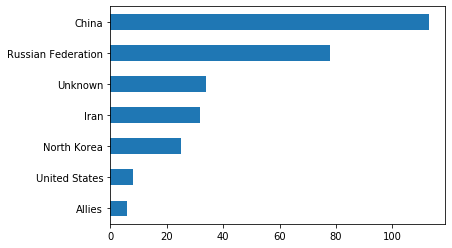

In [22]:
# over the last 10 years, China has been busy
plt = first.Sponsor.value_counts().sort_values(ascending=True).tail(7).plot(kind="barh")

In [23]:
just3 = first[first['Year']>2016]
just3 = just3[just3.Sponsor!='Allies']
just3 = just3[just3.Sponsor!='China/Russia']
#just3.Sponsor.replace({'Netherlands':"Other",'Spain':"Other",'France':"Other",'Panama':"Other",'Ethiopia':"Other",
#                'Korea (Republic of)':"Other",'India':"Other",'United Kingdom':"Other",'Kazakhstan':"Other",
#                'Lebanon':"Other"},inplace=True)
just3 = pd.DataFrame(just3.groupby('Year').Sponsor.value_counts())
just3 = just3.rename({'Sponsor':'totals'},axis=1)
just3 = just3.reset_index()
just3.loc[just3.totals < 3, 'Sponsor'] = "Other"
just3 = pd.DataFrame(just3.groupby(['Year','Sponsor']).totals.sum())
just3 = just3.reset_index()
just3 = just3.pivot(index='Year', columns='Sponsor', values='totals')
just3

Sponsor,China,Iran,North Korea,Other,Russian Federation,United States,Unknown
Year,,,,,,,
2017,6.0,6.0,4.0,5.0,17.0,3.0,5.0
2018,17.0,6.0,9.0,8.0,25.0,NaN,15.0
2019,6.0,3.0,NaN,4.0,3.0,NaN,NaN


In [24]:
just3.columns

Index(['China', 'Iran', 'North Korea', 'Other', 'Russian Federation',
       'United States', 'Unknown'],
      dtype='object', name='Sponsor')

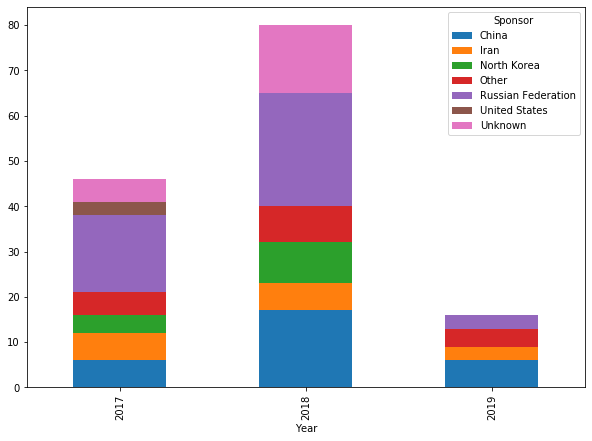

In [25]:
#going to turn it into percentage graph in Flourish Studio
just3.plot.bar(stacked=True, figsize=(10,7))

In [26]:
# espionage is so far out of the range compared to others, using the treemap is useful
first.Type.value_counts().sort_values(ascending=False)

Espionage            262
Denial of service     17
Sabotage              16
Data destruction      10
Uncateogrized          9
Doxing                 6
Defacement             3
Name: Type, dtype: int64

In [27]:
typedf=pd.DataFrame(first.groupby(['Year','Sponsor']).Type.value_counts())
typedf=typedf.rename({'Type':'counts'},axis=1)
typedf=typedf.reset_index()
typedf.to_csv('data/treemapdata.csv', index=False)
typedf
#import into Flourish studio

,Year,Sponsor,Type,counts
0,2005,China,Espionage,1
1,2006,China,Espionage,3
2,2007,Allies,Denial of service,1
3,2007,China,Espionage,7
4,2007,Israel,Denial of service,1
5,2007,Russian Federation,Denial of service,1
6,2008,China,Espionage,5
7,2008,Russian Federation,Denial of service,1
8,2008,Russian Federation,Espionage,1
9,2009,China,Espionage,3


In [33]:
first.Category.value_counts()

Private sector                               90
Government                                   73
Government, Private sector                   41
Civil society                                35
Military                                     20
Government, Military                         16
Private sector, Government                   11
Military, Government                          8
Government, Private sector, Civil society     7
Government, Civil society                     7
Civil society, Private sector                 3
Military, Private sector                      3
Private sector, Military                      3
Military, Civil society                       2
Civil society, Government                     1
Private sector, Civil society                 1
Government, Civil society, Private sector     1
Government, Military, Private sector          1
Name: Category, dtype: int64

In [29]:
categories = first.copy()

In [30]:
categories.Category.value_counts()

Private sector                               90
Government                                   73
Government, Private sector                   41
Civil society                                35
Military                                     20
Government, Military                         16
Private sector, Government                   11
Military, Government                          8
Government, Private sector, Civil society     7
Government, Civil society                     7
Civil society, Private sector                 3
Military, Private sector                      3
Private sector, Military                      3
Military, Civil society                       2
Civil society, Government                     1
Private sector, Civil society                 1
Government, Civil society, Private sector     1
Government, Military, Private sector          1
Name: Category, dtype: int64

In [31]:
categories.Category.replace({'Government, Military':'Government',
                            'Military, Government':'Military',
                            'Private sector, Military':'Private sector',
                            'Military, Civil society':'Military',
                            'Military, Private sector':'Military',
                            'Government, Military, Private sector':'Military',
                            'Government, Private sector':'Government',
                            'Private sector, Government':'Private sector',
                            'Government, Civil society':'Government',
                            'Government, Private sector, Civil society':'Private sector',
                            'Civil society, Private sector':'Civil society',
                            'Civil society, Government':'Civil society',
                            'Private sector, Civil society':'Private sector',
                            'Government, Civil society, Private sector':'Civil society'}, inplace=True)

In [32]:
categories.Category.value_counts()

Government        137
Private sector    112
Civil society      40
Military           34
Name: Category, dtype: int64

In [41]:
categories = categories[['Sponsor','Type','Category','Year']]
categories.to_csv('data/categoesi.csv', index=False)
categories

,Sponsor,Type,Category,Year
0,China,Data destruction,Private sector,2019
1,United Arab Emirates,Espionage,Government,2019
2,China,Espionage,Private sector,2019
3,Russian Federation,Espionage,Private sector,2019
4,United States,Sabotage,Military,2019
5,China,Espionage,Private sector,2019
6,Allies,Espionage,Private sector,2019
7,United States,Denial of service,Government,2019
8,Iran,Data destruction,Private sector,2019
9,China,Espionage,Civil society,2019


In [ ]:
########## we don't do pie charts, but keeping this code in case I ever want to use a pie chart
#countries = ["China","Russian Federation","Unknown","Iran (Islamic Republic of)","Korea (Democratic People's Republic of)","United States","Israel"]
#top10 = pd.DataFrame(first.Sponsor.value_counts())
#top10 = top10.reset_index()
#top10 = top10.rename(index=str, columns={"index": "country"})
#top10.loc[~top10.country.isin(countries), 'country'] = "other"
#top10 = top10.groupby('country').sum()
#top10 = pd.DataFrame(top10.Sponsor.sort_values(ascending=False))
#top10

In [ ]:
#plot = top10.plot.pie(y='Sponsor', figsize=(20, 20))
##########end pie chart code